# Aircraft Performance

Aircraft performance affects engine emissions and contrail formation.

`pycontrails` includes built-in support for two aircraft performance models:

- [Poll-Schumann Model](https://doi.org/10.1017/aer.2020.62)
- [BADA](https://www.eurocontrol.int/model/bada) (*Requires [pycontrails-bada](https://github.com/contrailcirrus/pycontrails-bada) extension and data files obtained through the [BADA license](https://www.eurocontrol.int/model/bada).*)

## Alternate Models

Aircraft performance can be pre-computed and provided directly to models.
Other performance models include:

- [OpenAP](https://openap.dev/): Open-source aircraft performance and emissions model
- [PianoX](https://www.lissys.uk/PianoX.html): Aircraft design, performance, and emissions tool

Aircraft OEMs and flight planning systems generally have the most accurate performance models.

## Poll-Schumann Trajectory Model

The Poll-Schumann model was developed to address the need for simple, yet accurate, methods for the estimation of cruise fuel burn and other important aircraft performance parameters.

### References

- D.I.A. Poll and U. Schumann. An estimation method for the fuel burn and other performance characteristics of civil transport aircraft in the cruise. Part 1 fundamental quantities and governing relations for a general atmosphere. The Aeronautical Journal, 125(1284):257–295, February 2021. [doi:10.1017/aer.2020.62](https://doi.org/10.1017/aer.2020.62).
- D.I.A. Poll and U. Schumann. An estimation method for the fuel burn and other performance characteristics of civil transport aircraft during cruise: part 2, determining the aircraft's characteristic parameters. The Aeronautical Journal, 125(1284):296–340, February 2021. [doi:10.1017/aer.2020.124](https://doi.org/10.1017/aer.2020.124).


In [ ]:
import pandas as pd

from pycontrails import Flight
from pycontrails.physics import units

from pycontrails.models.ps_model import PSFlight

In [ ]:
# load flight
attrs = {"flight_id": "1", "aircraft_type": "A320"}
flight = Flight(data=pd.read_csv("flight2.csv"), attrs=attrs)

# select waypoints between initial climb and final decent
flight = flight.filter(flight["altitude"] > units.ft_to_m(33000))

# Estimate temperature using ISA
flight["air_temperature"] = units.m_to_T_isa(flight["altitude"])

# Estimate airspeed by using groundspeed
flight["true_airspeed"] = flight.segment_groundspeed()

In [ ]:
# Create PS Flight model and evaluate
ps_model = PSFlight()
out = ps_model.eval(flight)

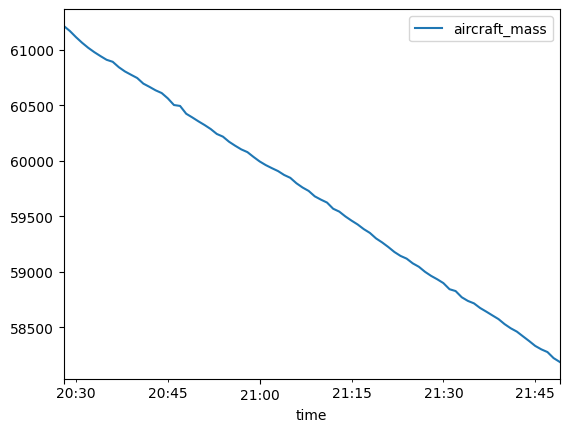

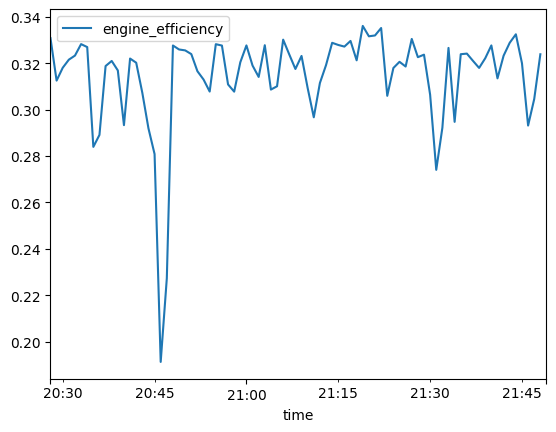

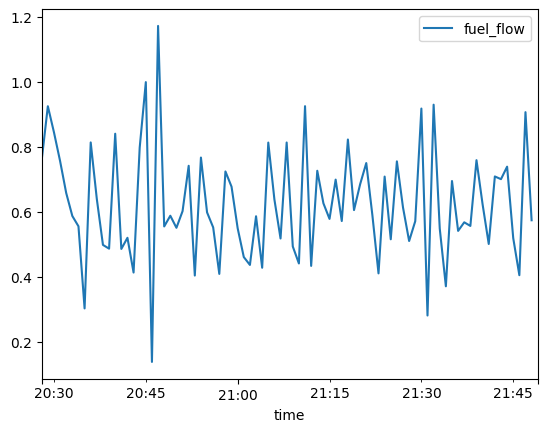

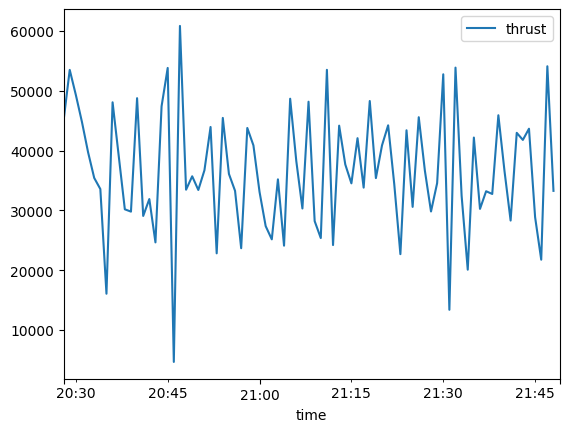

In [ ]:
# Visualize outputs
out.dataframe.plot(x="time", y="aircraft_mass")
out.dataframe.plot(x="time", y="engine_efficiency")
out.dataframe.plot(x="time", y="fuel_flow")
out.dataframe.plot(x="time", y="thrust");

## Poll-Schumann Grid Model

The `PSGrid` model exists to compute nominal Poll-Schumann aircraft performance
on a meteorological grid.

### Goal

For a given aircraft type, altitude, aircraft mass, air temperature, and
mach number, the PS model computes a theoretical engine efficiency and fuel
flow rate for an aircraft under cruise conditions. Letting the aircraft mass
vary and fixing the other parameters, the engine efficiency curve attains a
single maximum at a particular aircraft mass. By solving this implicit
equation, the PS model can be used to compute the aircraft mass that
maximizes engine efficiency for a given set of parameters. This is the
"nominal" aircraft mass computed by this model.

This nominal aircraft mass is not always realizable. For example, the maximum
engine efficiency may be attained at an aircraft mass that is less than the
operating empty mass of the aircraft. This model determines the minimum and
maximum possible aircraft mass for a given set of parameters using a simple
heuristic. The nominal aircraft mass is then clipped to this range.

In [ ]:
from matplotlib import pyplot as plt

from pycontrails.datalib.ecmwf import ERA5

from pycontrails.models.ps_model import PSGrid

In [ ]:
# load meteorology data
time = "2022-03-01 07:00:00"
pressure_levels = [250]
variables = ["air_temperature"]

era5 = ERA5(time=time, variables=variables, pressure_levels=pressure_levels)
met = era5.open_metdataset()

In [ ]:
# Run PSGrid model
model = PSGrid(met, aircraft_type="A320")
out = model.eval()

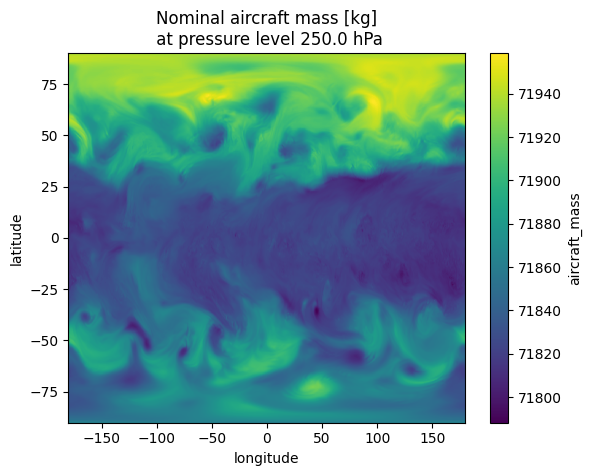

In [ ]:
out["aircraft_mass"].data.plot(x="longitude", y="latitude")
plt.title(f"Nominal aircraft mass [kg]\n at pressure level {out.data['level'].values[0]} hPa");

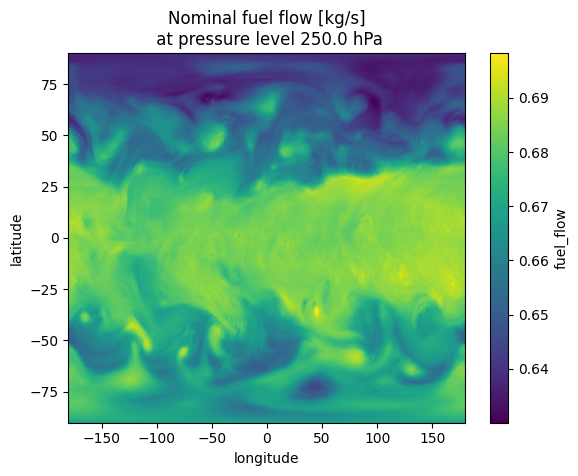

In [ ]:
out["fuel_flow"].data.plot(x="longitude", y="latitude")
plt.title(f"Nominal fuel flow [kg/s]\n at pressure level {out.data['level'].values[0]} hPa");